In [2]:
episodefile = open("../data/EpisodeList.txt","r")
episodeList = []

for line in episodefile:
    episodeList.append(line.strip().lower().replace(",",""))

SeasonList = [10,10,10,10,10,10,7,6]
episodeTuple = []
ekstranumb = 0
for numb in range(len(SeasonList)):
    for i in range(SeasonList[numb]):
        episodeTuple.append((numb+1, episodeList[i+ekstranumb]))
    ekstranumb += SeasonList[numb]

In [3]:
import lyricsgenius
genius = lyricsgenius.Genius("Apa5yYNZVRkIvn1izsQWN5l957pSR9jiG24s8ExAPKE9FHY9gdq4W8P7GPavWn1n")
artist = genius.search_artist("Game of Thrones")
artist.save_lyrics()

Searching for songs by Game of Thrones...

Song 1: "Winter is Coming"
Song 2: "Tyrion’s Courtroom Speech from The Laws of Gods and Men"
Song 3: "Kill the Boy"
Song 4: "Mother’s Mercy"
Song 5: "The Kingsroad"
Song 6: "The House of Black and White"
Song 7: "The Children"
Song 8: "Hardhome"
Song 9: "Liste des personnages"
Song 10: "The Wars to Come"
Song 11: "The Queen’s Justice"
Song 12: "Lord Snow"
Song 13: "High Sparrow"
Song 14: "The Dance of Dragons"
Song 15: "The Wolf and the Lion"
Song 16: "Cripples, Bastards and Broken Things"
Song 17: "The Winds of Winter"
Song 18: "Battle of the Bastards"
Song 19: "Book of the Stranger"
Song 20: "The Door"
Song 21: "The Red Woman"
Song 22: "You Win or You Die"
Song 23: "The North Remembers"
Song 24: "The Pointy End"
Song 25: "The Mountain and the Viper"
Song 26: "Unbowed, Unbent, Unbroken"
Song 27: "Oathbreaker"
Song 28: "The Gift"
Song 29: "Dragonstone"
Song 30: "A Golden Crown"
Song 31: "Fire and Blood"
Song 32: "The Rains of Castamere"
Song 3

In [3]:
import json
jFile = open("Lyrics_GameofThrones.json", "r")
j = json.load(jFile)

#Ignore this
#Dont even worry about it
#Just a simple Dict comprehension, no need to analyze it
LyricsListDict = {j["songs"][w]["title_with_featured"].lower().replace(",",""):j["songs"][w]["lyrics"].encode("UTF-8").decode("UTF-8") 
                    for w in range(len(j["songs"])) 
                    if j["songs"][w]["title_with_featured"].lower().replace(",","") in episodeList}



In [89]:
SeasonDict = dict()
#SeasonDict format
# {Title:{Season:SeasonNumber,Script:ScriptText}}
episode1counter = 0
for season, title in episodeTuple:
    if season != 1:
        SeasonDict[title] = {"season": season,"script":LyricsListDict[title]}
    else:
        episode1counter += 1
        script = ""
        path = f"../data/GOT_Season_1_Formatted/Episode{episode1counter}.txt"
        print(path)
        with open(f"../data/GOT_Season_1_Formatted/Episode{episode1counter}.txt",'r') as file:
            script = file.readlines()
        SeasonDict[title] = {"season": season,"script":script}
print(SeasonDict['winter is coming'])


../data/GOT_Season_1_Formatted/Episode1.txt
../data/GOT_Season_1_Formatted/Episode2.txt


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 35: invalid start byte

In [5]:

def sceneNameChecker(screenLine:str, i:int, lineSplit:str, sceneList:list):
    
    sceneName = None
    

    if lineSplit[0].upper() == "CUT TO":
        sceneName = lineSplit[1].strip()

    elif screenLine.startswith('EXT'):
        sceneName = screenLine.strip()[4:].strip()

    elif screenLine.startswith('INT'):
        sceneName = screenLine.strip()[4:].strip()

    elif screenLine.strip().startswith("--------"):
        sceneName = "Unnamed Scene"

    elif screenLine.upper().strip().startswith("CUT TO"):
        sceneName = screenLine.strip()[7:].strip()

    elif "SCENE SHIFTS" in screenLine.upper() or "SCENE CHANGES" in screenLine.upper():
        sceneName = "Unnamed Scene"
        
    elif "NEWSCENE" in screenLine.upper():
        sceneName = "Unnamed Scene"
    elif i == 0:
        
        sceneName = "Unnamed Scene"

    

    #Giving the sceneName an extra number if the sceneName occurs multiple times
    if sceneName is not None:
        if str(sceneName) in sceneList:
            try:
                sceneNameOld = sceneName
                sceneName = str(sceneName) + "_" + str(sceneList.count(sceneName))
                sceneList.append(str(sceneNameOld))
                
            except TypeError as error:
                print("Error:", sceneName)
            
        else:
            sceneList.append(str(sceneName))
        
        return True, str(sceneName), sceneList
       
        
    return False, False, False


def createDataframefromDict(screenplayDict:dict):
 
    dfcolumns = ['Person','SeasonNr','EpisodeID','EpisodeTitle','Scene','ScreenLine']


    sceneList = []
    allLines = []
    episodeID = 0
    

    for title in screenplayDict:

        episodeTitle = title
        episodeID += 1
        seasonNr = screenplayDict[title]['season']

        sceneName = None

        screenLines = screenplayDict[title]['script'].replace("\n\n\n", "NEWSCENE\n")
        screenLines = screenLines.split("\n")[1:]
        

        for i in range(len(screenLines)):
            
            line = screenLines[i]

            lineSplit = line.strip().split(":")
            
            if len(lineSplit) > 1:

                if sceneNameChecker(line,i,lineSplit,sceneList)[0] is True:
                    _, sceneName, sceneList = sceneNameChecker(line,i,lineSplit, sceneList)
                    #print("Scene:", sceneName, "episode:", episodeID)
                    if "Scene shifts" in str(line) and len(line[0].strip()) > 0:

                        print(str(line))                

                elif len(lineSplit) >= 2:
                    if sceneName is None:
                        _, sceneName, sceneList = sceneNameChecker(line,0,lineSplit, sceneList)

                    person = str(lineSplit[0].split("(")[0].strip()).upper()
                    screenLine = str(lineSplit[1])
                    
                    newEntry = [person, seasonNr, episodeID, episodeTitle, sceneName, screenLine]
                    allLines.append(newEntry)
                    
                
            else:
                
                if "SCENE SHIFTS" in str(line).upper() or "SCENE CHANGES" in str(line).upper() and len(line[0].strip()) > 0:
                    
                    _, sceneName, sceneList = sceneNameChecker(line,0,lineSplit, sceneList)
                    
            


    df = pd.DataFrame(allLines,columns=dfcolumns)
    return df

In [6]:
import numpy as np
def format_name(person_list: list, verbose = False) -> list:
    metadata = pd.read_csv('../data/characher_metadata2.csv')
    c2n = pd.read_csv('../data/characterToName.csv', header = None)

    # 'One comprehenssion to rule them all, One comprehenssion to find them, One comprehenssion to bring them all and in the darkness bind them.
    alias2name = {alias.strip().lower():name.strip().lower() for alias, name in zip(c2n.iloc[:,0],c2n.iloc[:,1]) if alias is not np.nan and name is not np.nan}
    metadata_ls = [person.lower() for person in metadata.iloc[:,0]]
    metadata_uniq = set(metadata_ls)

    
    valid_persons = []
    for person in person_list:
        person = person.lower()
        person = person.replace('king', '')
        person = person.replace('young', '')
        person = person.replace('ser', '')
        person = person.replace('lord', '')
        person = person.replace('maester', '')
        person = person.replace('grand maester', '')
        person = person.strip()
    
        if person in metadata_uniq:
            valid_persons.append(person)
    #ic(valid_persons)
            
        if person not in metadata_uniq:
            if person in alias2name:
                valid_persons.append(alias2name[person])
                if verbose and person != alias2name[person]:
                    print(f'{person} -> {alias2name[person]}')
                    pass
            else:
                valid_persons.append(np.nan)
                if verbose:
                    print(f'{person} -> nan')
    return valid_persons

In [7]:
import pandas as pd
df = createDataframefromDict(SeasonDict)
#print(df)
df["Person"] = format_name(df.Person, verbose = False)

pd.DataFrame.dropna(df,axis=0, how = 'any', inplace = True)
print(df)

                 Person  SeasonNr  EpisodeID      EpisodeTitle  \
0          waymar royce         1          1  winter is coming   
1                  will         1          1  winter is coming   
2          waymar royce         1          1  winter is coming   
3                  will         1          1  winter is coming   
4                 gared         1          1  winter is coming   
...                 ...       ...        ...               ...   
25035               sam         8         73   the iron throne   
25036             bronn         8         73   the iron throne   
25037  brienne of tarth         8         73   the iron throne   
25038             bronn         8         73   the iron throne   
25039  tyrion lannister         8         73   the iron throne   

                         Scene  \
0                Unnamed Scene   
1                Unnamed Scene   
2                Unnamed Scene   
3                Unnamed Scene   
4                Unnamed Scene   
...

In [81]:
import json
import ast
import pandas as pd
D = pd.read_csv('../data/characher_metadata2.csv')
houseDict = dict()
for name, i in zip(D.iloc[:,0],D.iloc[:,1]):
    if i.strip('[]') != '':   
        i = ast.literal_eval(i)
        affiliations = []
        for house in i:
            affiliations.append(house.split("/")[0])
            
        houseDict[name.lower()] = set(affiliations)
print(houseDict)
count = 0
for name, house in houseDict.items():
    if len(house) > 2:
        print(name, house)
        count+= 1

{'alannys greyjoy': {'House Harlaw', 'House Greyjoy'}, 'janos slynt': {'House Slynt'}, 'viserys i targaryen': {'House Targaryen'}, 'aerion targaryen': {'House Targaryen'}, 'daenerys targaryen (daughter of aegon iv)': {'House Targaryen', 'House Martell'}, 'prince of dorne (last war)': {'House Martell'}, 'aegon iv targaryen': {'House Targaryen'}, 'harald karstark': {'House Karstark'}, 'yezzan zo qaggaz': {'House of Qaggaz'}, 'leo lefford': {'House Lefford'}, 'talla tarly': {'House Tarly'}, 'vardis egen': {'House Egen'}, 'symun fossoway': {'House Fossoway (disambiguation)'}, 'imry florent': {'House Florent'}, 'podrick_payne': {'House Payne'}, 'balon swann': {'House Swann'}, 'aerys ii targaryen': {'House Targaryen'}, 'anya waynwood': {'House Waynwood'}, 'daemon targaryen': {'House Targaryen'}, 'steffon baratheon': {'House Baratheon'}, 'willas tyrell': {'House Tyrell'}, 'torrhen karstark': {'House Karstark'}, 'harren hoare': {'House Hoare'}, 'cersei lannister': {"House Baratheon of King's L

In [82]:
lineDict = dict()

# LineDict -> key: Scene -> key: person -> value: lines
#                        -> value: seasonnr
#                        -> value: EpisodeID
#                        -> value: EpisodeTitle

for scene, person, lines, seasonNr, episodeID, episodeTitle in zip(df.Scene, df.Person, df.ScreenLine, df.SeasonNr, df.EpisodeID, df.EpisodeTitle):
    if scene not in lineDict:
        lineDict[scene] = {}
  
    if person not in lineDict[scene]:
        lineDict[scene][person] = {}
        lineDict[scene][person]["SeasonNr"] = seasonNr
        lineDict[scene][person]["EpisodeID"] = episodeID
        lineDict[scene][person]["EpisodeTitle"] = episodeTitle
        
    if "lines" not in lineDict[scene][person]: 
        lineDict[scene][person]["lines"] = []
    

    lineDict[scene][person]["lines"].append(lines)


print("Nr of scenes in dict:", len(lineDict))
#lineDict["Unnamed Scene"]




Nr of scenes in dict: 991


In [83]:
import networkx as nx
import pickle

G = nx.DiGraph()
PersonList = set(list(df.Person))
print(PersonList)

nodeList = []
for person in personList:
    if person in houseDict:
        nodeList.append((person, {"affiliation": houseDict[person]}))
    else:
        nodeList.append((person))
print(nodeList)
#print(houseDict)
G.add_nodes_from(nodeList)
#G.set_node_attributes(G,houseDict, "a


for scene in lineDict:    
    connectedPersons = list(lineDict[scene])

    for person in lineDict[scene]:
        lines = lineDict[scene][person]["lines"]
        
        if connectedPersons is not None:
            for connectedName in connectedPersons:
                if person != connectedName:
                    G.add_edge(person, connectedName, lines = lines, weight = len(lines), seasonNr = lineDict[scene][person]["SeasonNr"], episodeTitle= lineDict[scene][person]["EpisodeTitle"])


print(G.nodes(data = True))

file = open("GOTNetwork.pkl",'wb')
pickle.dump(G,file)

{'slaver', 'greatjon umber', 'clarenzo', 'edmure tully', 'lommy', 'qhorin', 'knight of house bracken', 'white rat', 'champion', 'amory lorch', 'mossador', 'ellaria sand', "mole's town madam", 'dontos hollard', 'cressen', "morgan's friend", 'lysa arryn', 'craya', 'vale (name not provided)', 'gerard', 'asha greyjoy', 'olly', 'hooded figure (name not provided)', 'sam', 'house manderly', 'doreah', 'unsullied captain', 'kovarro', 'selyse baratheon', 'steward', 'tansy', 'septa', 'jory cassel', 'high septon', 'head prostitute (name not provided)', 'mero', 'sandor clegane', 'styr', 'elder meereen slave', 'ramsay bolton', 'varys', 'winterfell shepherd', 'cohollo', 'septa unella', 'mance rayder', 'knight of house whent (name not provided)', 'brienne of tarth', 'vicky', 'brynden tully (blackfish)', 'walda frey', 'yara greyjoy', 'lollys stokeworth', 'barristan selmy', 'obara sand', 'khal moro', 'lady crane', "jaqen h'ghar", 'innkeeper', 'stevron frey', 'riverlands', 'first mate', 'jhiqui', 'lothar

In [12]:
d = dict(G.degree): {
pos = nx.kamada_kawai_layout(G)


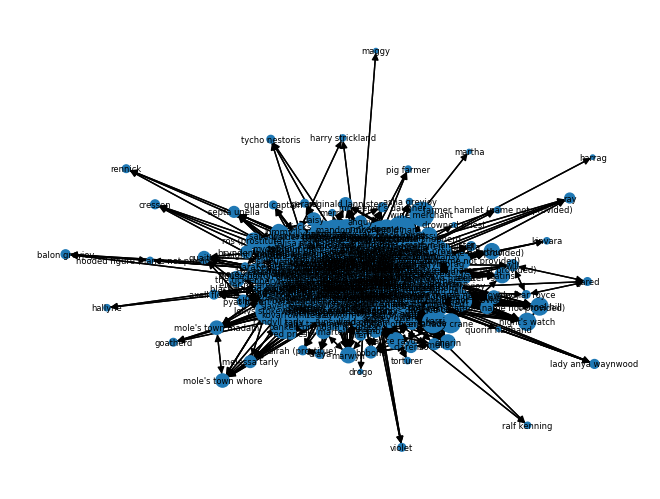

In [405]:
nx.draw(G, pos = pos, node_size=[v * 5 for v in d.values()], with_labels = True, font_size = 6)

In [406]:
nx.draw(G, pos = pos, node_size=[v * 5 for v in d.values()])